# Momentum Contrarian Backtester

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.exceptions import V20Error

class ConBacktester():
    def __init__(self, instrument, start, end, tc, granularity, price, access_token):
        self.instrument = instrument
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.granularity = granularity
        self.price = price
        self.access_token = access_token
        self.params = {
            "granularity": self.granularity,
            "from": self.start,
            "to": self.end
        }
    
        self.client = API(access_token=access_token, environment="practice")
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25)) # NEW



    def __repr__(self):
         return "ConBacktester(instrument = {}, start = {}, end = {}, tc = {}, granularity = {}, price = {})".format(self.instrument, self.start, self.end, self.tc, self.granularity, self.price)
        

    def get_data(self):

        access_token = '65ea0aa854d23214e7ecab3851b38115-003a1258c7194456707c1e4d45bc6d33'

        client = API(access_token=access_token, environment="practice")

        params = {
            "granularity": self.granularity,
            "from": self.start,
            "to": self.end
        }

        # Get the historical pricing data for the EUR/USD pair
        instrument = "EUR_USD"
        r = instruments.InstrumentsCandles(instrument=instrument, params=params)
        try:
            response = client.request(r)
        except V20Error as e:
            print(f"Error: {e}")

        # Parse the response into a Pandas DataFrame
        data = pd.DataFrame(response['candles'])
        data['time'] = pd.to_datetime(data['time'], format="%Y-%m-%dT%H:%M:%S.%f000Z")
        data.set_index('time', inplace=True)
        data.sort_index(inplace=True)

        # Extract only the 'c' values from the 'mid' column
        data['c'] = data['mid'].apply(lambda x: x['c'])
        data.rename(columns={'c': 'price'}, inplace=True)
        data['price'] = pd.to_numeric(data['price'], errors='coerce')
        data.drop(columns=['complete', 'mid', 'volume'], inplace=True)
        data["returns"] = np.log(data['price']/ data['price'].shift(1))
        self.data = data


    def test_strategy(self, window = 1):
            '''
            Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
            
            Parameters
            ============
            window: int
                time window (number of bars) to be considered for the strategy.
            '''
            self.window = window
                                    
            self.prepare_data(window)
            self.run_backtest()
            
            data = self.results.copy()
            data["creturns"] = data["returns"].cumsum().apply(np.exp)
            data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
            self.results = data
            
            self.print_performance()
            

    def prepare_data(self, window):
        
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {}".format(self.instrument, self.window)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))


    def optimize_strategy(self, window_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | {}: {}".format(window, self.metric, round(perf, 6))) # updated

        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | {} vs Windows".format(self.metric), fontsize = 15) # updated
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("{}".format(self.metric), fontsize = 15) # updated

        


 ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | WINDOW = {}".format(self.instrument, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    

        
        

### Creating an instance of the class

In [47]:
trader = ConBacktester('EUR_USD','2010-01-01', '2011-01-04', .00007, 'H12', '65ea0aa854d23214e7ecab3851b38115-003a1258c7194456707c1e4d45bc6d33', 'A')


### Getting the data and printing it

In [48]:
trader.get_data()

In [49]:
trader.data

,price,returns
time,,
2009-12-31 22:00:00,1.43120,NaN
2010-01-03 10:00:00,1.43036,-0.000587
2010-01-03 22:00:00,1.43948,0.006356
2010-01-04 10:00:00,1.44127,0.001243
2010-01-04 22:00:00,1.44320,0.001338
...,...,...
2010-12-31 22:00:00,1.33885,0.000366
2011-01-02 10:00:00,1.33471,-0.003097
2011-01-02 22:00:00,1.32868,-0.004528


### Testing the strategy

In [50]:
trader.test_strategy()

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EUR_USD | WINDOW = 1
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.81416
Multiple (Buy-and-Hold):     0.936715
--------------------------------------
Out-/Underperformance:       -0.122555


CAGR:                        -0.185955
Annualized Mean:             -0.204714
Annualized Std:              0.121002
Sharpe Ratio:                -1.691825
Sortino Ratio:               -2.292056
Maximum Drawdown:            0.203625
Calmar Ratio:                -0.913221
Max Drawdown Duration:       362 Days
Kelly Criterion:             -13.481549


### Running the backtest and plotting the results
#### creturns = buy and hold

In [51]:
trader.run_backtest()

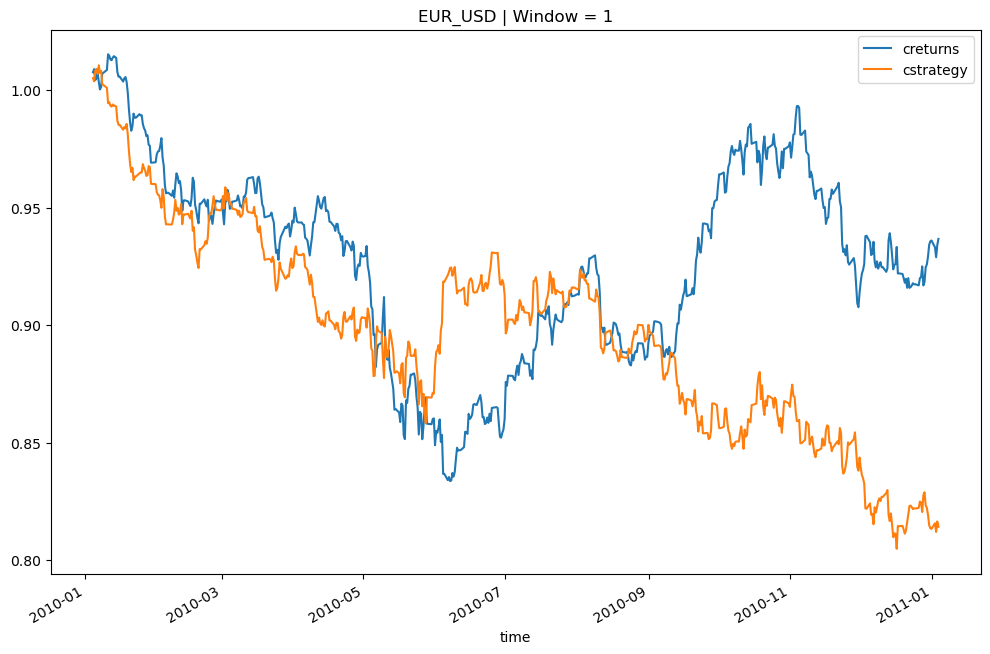

In [52]:
trader.plot_results()

### Calculating the best parameter and printing out its results

In [53]:
trader.optimize_strategy((1,200), "Multiple")

Windows: 16 | Multiple: 1.114375
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EUR_USD | WINDOW = 16
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.114375
Multiple (Buy-and-Hold):     0.924614
--------------------------------------
Out-/Underperformance:       0.189761


CAGR:                        0.117515
Annualized Mean:             0.110475
Annualized Std:              0.122746
Sharpe Ratio:                0.900029
Sortino Ratio:               1.287233
Maximum Drawdown:            0.100131
Calmar Ratio:                1.173616
Max Drawdown Duration:       147 Days
Kelly Criterion:             7.835538


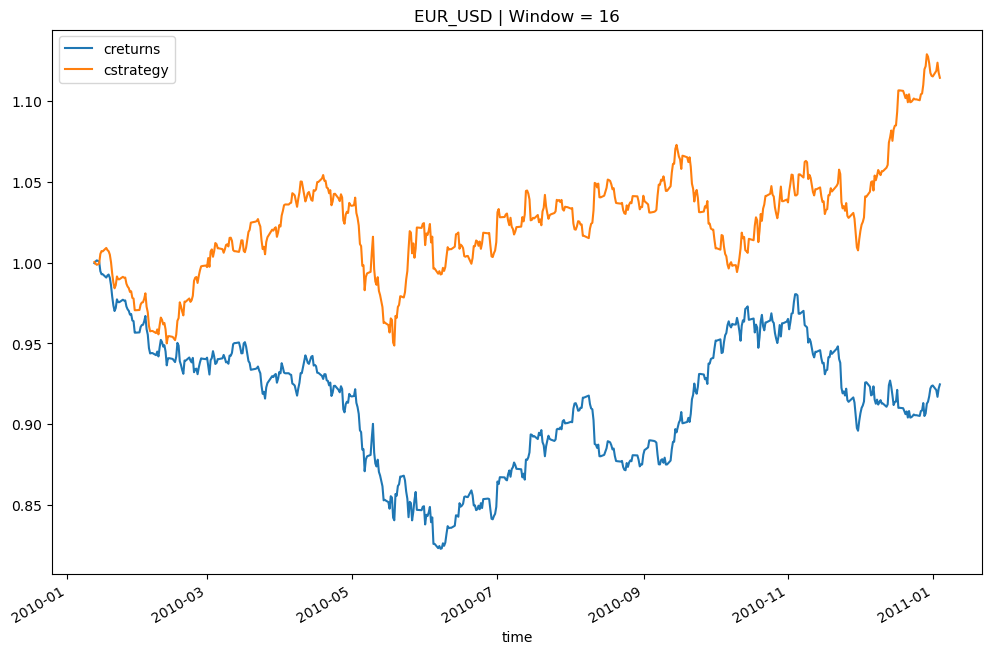

In [54]:
trader.plot_results()

### Visualizing the multiple vs windows

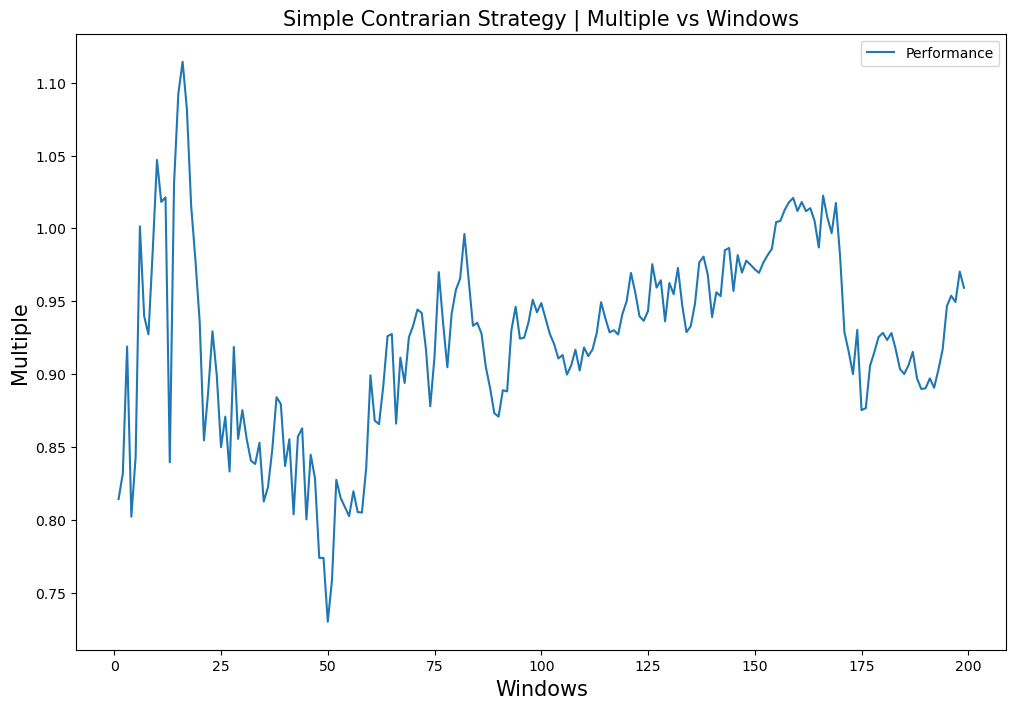

In [55]:
trader.visualize_many()